In [114]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed,  Flatten, Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.optimizers import Adam
from tqdm.keras import TqdmCallback
from keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Add the python path to the folder containing some useful custom packages.
import sys
sys.path.insert(0, "../../packages/")
from TsIP.TsIP import TsIP
from tools import find_multiple_sets
from LagsCreator.LagsCreator import LagsCreator

## Dataset

In [3]:
COUNTRIES = ["Yemen", "Syria"]

In [4]:
PATH_TO_DATA_FOLDER = lambda x: "../../Dataset time-series/data/" + x + "/"

In [55]:
trains = list()
trains_smooth = list()
tests = list()
targets = list()
for country in COUNTRIES:
    # Load the dataset of the training sets.
    train = pd.read_csv(PATH_TO_DATA_FOLDER(country) + "train.csv", header = [0, 1], index_col = 0)
    train.index.name = "Datetime"
    train.index = pd.to_datetime(train.index)
    freq = "D"
    train.index.freq = freq
    train.columns = pd.MultiIndex.from_tuples(map(lambda x: (country, x[0], x[1]), train.columns))
    trains.append(train)
    # Load the dataset of the smoothed training sets.
    train_smooth = pd.read_csv(PATH_TO_DATA_FOLDER(country) + "train_smooth.csv", header = [0, 1], index_col = 0)
    train_smooth.index.name = "Datetime"
    train_smooth.index = pd.to_datetime(train_smooth.index)
    freq = "D"
    train_smooth.index.freq = freq
    train_smooth.columns = pd.MultiIndex.from_tuples(map(lambda x: ("Smooth_" + country, x[0], x[1]), train_smooth.columns))
    trains_smooth.append(train_smooth)
    # Load the dataset of the test sets.
    test = pd.read_csv(PATH_TO_DATA_FOLDER(country) + "test_target.csv", header = [0, 1], index_col = 0)
    test.index.name = "Datetime"
    test.index = pd.to_datetime(test.index)
    freq = "D"
    test.index.freq = freq
    test.columns = pd.MultiIndex.from_tuples(map(lambda x: (country, x[0], x[1]), test.columns))
    tests.append(test)
    # Load the dataset of the whole time-series of the fcs indicator.
    target = pd.read_csv(PATH_TO_DATA_FOLDER(country) + "all_target.csv", header = [0, 1], index_col = 0)
    target.index.name = "Datetime"
    target.index = pd.to_datetime(target.index)
    freq = "D"
    target.index.freq = freq
    target.columns = pd.MultiIndex.from_tuples(map(lambda x: (country, x[0], x[1]), target.columns))
    targets.append(target)

In [56]:
train = pd.concat(trains, axis = 1)
train.columns.rename("Country", level = 0, inplace = True)
train.columns.rename("AdminStrata", level = 1, inplace = True)
train.columns.rename("Indicator", level = 2, inplace = True)
freq = "D"
train.index.freq = freq
train.dropna(axis = 0, how = "all", inplace = True)

In [57]:
train_smooth = pd.concat(trains_smooth, axis = 1)
train_smooth.columns.rename("Country", level = 0, inplace = True)
train_smooth.columns.rename("AdminStrata", level = 1, inplace = True)
train_smooth.columns.rename("Indicator", level = 2, inplace = True)
freq = "D"
train_smooth.index.freq = freq
train_smooth.dropna(axis = 0, how = "all", inplace = True)

In [58]:
test = pd.concat(tests, axis = 1)
test.columns.rename("Country", level = 0, inplace = True)
test.columns.rename("AdminStrata", level = 1, inplace = True)
test.columns.rename("Indicator", level = 2, inplace = True)
freq = "D"
test.index.freq = freq

In [73]:
target = pd.concat(targets, axis = 1)
target.columns.rename("Country", level = 0, inplace = True)
target.columns.rename("AdminStrata", level = 1, inplace = True)
target.columns.rename("Indicator", level = 2, inplace = True)
freq = "D"
target.index.freq = freq

In [78]:
TEST_SIZE = 30
FREQ = train.index.freq

In [79]:
TRAIN = train.copy()
TRAIN_SMOOTH = train_smooth.copy()

## Data source transformation

I decide to normalize the data among the provinces considering indicator by indicator and considering only the training sets.

In [86]:
global SCALERS

MIN = 0
MAX = 1
SCALERS = dict()
def normalization(group, feature_range):
    min_, max_ = feature_range
    min_group = group.min().min()
    max_group = group.max().max()
    
    # Normalization.
    group_std = (group - min_group) / (max_group - min_group)
    group_scaled = group_std * (max_ - min_) + min_

    # Save the scalers for the various indicators.
    SCALERS[group.name] = (min_group, max_group)

    return group_scaled

In [87]:
TRAIN_NORMALIZED = pd.concat([TRAIN, TRAIN_SMOOTH], axis = 1).groupby(axis = 1, level = 2).apply(lambda x: normalization(x, (MIN, MAX)))

In [92]:
# Plot time-series.
#TsIP(TRAIN_NORMALIZED).interactive_plot_df(title = "Training sets", matplotlib = False, style = "lines", first_last_valid_index_group = True)

In [93]:
def denormalization(group_scaled, indicator, feature_range, scalers):
    min_, max_ = feature_range
    min_group, max_group = scalers[indicator]

    group_std = (group_scaled - min_) / (max_ - min_)
    group = (group_std * (max_group - min_group)) + min_group
    
    return group

## Training

In [133]:
N_SEQ = 2
N_STEPS = 7
LAGS = N_SEQ*N_STEPS

In [134]:
lags_dict = dict()
# Define lags for each indicator.
lags_dict["3 Months Anomaly (%) Rainfall"] = LAGS
lags_dict["1 Month Anomaly (%) Rainfall"] = None
lags_dict["Cereals and tubers"] = LAGS
lags_dict["Exchange rate (USD/LCU)"] = LAGS
lags_dict["FCS"] = LAGS
lags_dict["Fatality"] = LAGS
lags_dict["NDVI Anomaly"] = LAGS
lags_dict["Rainfall (mm)"] = LAGS
lags_dict["rCSI"] = LAGS
lags_dict["Lat"] = None
lags_dict["Lon"] = None
lags_dict["Population"] = LAGS
lags_dict["Ramadan"] = LAGS

In [135]:
COUNTRIES = TRAIN_NORMALIZED.columns.get_level_values(0).unique()
COUNTRIES

Index(['Yemen', 'Syria', 'Smooth_Yemen', 'Smooth_Syria'], dtype='object', name='Country')

In [136]:
# Creation of training and validation points.
X_train_list, y_train_list, X_val_list, y_val_list = list(), list(), list(), list()
for COUNTRY in COUNTRIES:
    subdf = TRAIN_NORMALIZED[COUNTRY]
    TRAIN_NORMALIZED_SETS = find_multiple_sets(subdf.loc[subdf.first_valid_index():subdf.last_valid_index()])      
    PROVINCES = subdf.columns.get_level_values(0).unique()  

    for i, train_normalized in enumerate(TRAIN_NORMALIZED_SETS):
        # Create training points from the training set.
        for PROVINCE in PROVINCES:
            # Initialize lags creator.
            creator = LagsCreator(train_normalized[[PROVINCE]], lags_dictionary = lags_dict, n_out = TEST_SIZE, target = "FCS", 
                                  return_dataframe = False)
            # Get samples.
            X_train, y_train, X_val, y_val, _ = creator.to_supervised(single_step = False, feature_time = False, validation = True, 
                                                                      dtype = np.float64)
            
            # Add a list of all the training samples of all the provinces together.
            X_train_list.append(X_train)
            y_train_list.append(y_train)
            X_val_list.append(X_val)
            y_val_list.append(y_val)

X_train = np.concatenate(X_train_list)
y_train = np.concatenate(y_train_list)
X_val = np.concatenate(X_val_list)
y_val = np.concatenate(y_val_list)

print("Training shape: X:", X_train.shape, "y:", y_train.shape)
print("Validation shape: X:", X_val.shape, "y:", y_val.shape)

Training shape: X: (19580, 14, 10) y: (19580, 30)
Validation shape: X: (180, 14, 10) y: (180, 30)


In [137]:
N_FEATURES = X_train.shape[2]

In [138]:
def network(timesteps, features, n_out):      
    model = Sequential() 

    # MODEL.
    model.add(TimeDistributed(Conv1D(3, 2, activation = "relu", input_shape = (None, N_STEPS, N_FEATURES))))
    #model.add(TimeDistributed(Conv1D(64, 3, activation = "relu", )))
    model.add(TimeDistributed(MaxPooling1D(pool_size = 2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(10, activation = "relu", return_sequences = False))
    #model.add(Dropout(0.2))

    model.add(Dense(n_out))  

    return model

In [139]:
N_EPOCHS = 1000
BATCH_SIZE = 128

In [140]:
X_train = X_train.reshape((X_train.shape[0], N_SEQ, N_STEPS, N_FEATURES))
X_val = X_val.reshape((X_val.shape[0], N_SEQ, N_STEPS, N_FEATURES))

In [ ]:
print("Training network:")

# Model.
model = network(LAGS, N_FEATURES, TEST_SIZE)
# Compile model.
model.compile(loss = "mse", optimizer = Adam(lr = 0.001))

# Patient early stopping.
es = EarlyStopping(monitor = "val_loss", mode = "min", verbose = 1, patience = 100)
# Fit model.
history = model.fit(X_train, y_train, epochs = N_EPOCHS, validation_data = (X_val, y_val), batch_size = BATCH_SIZE, 
                    verbose = 0, shuffle = True, callbacks = [es, TqdmCallback(verbose = 1)])

# Plot result of the training and validation.
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc = "upper left")
plt.show()

Training network:


# Example predict on sample

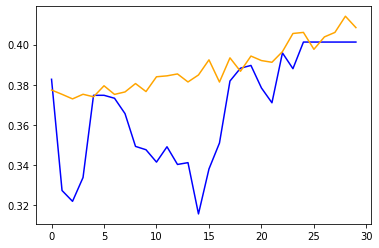

In [132]:
# Training sample.

id_ = 400

X_test = np.expand_dims(X_train[id_], axis = 0)

pred = model.predict(X_test).flatten()
actual = y_train[id_]

# Plot the predictions.
plt.plot(actual, "blue")
plt.plot(pred, "orange");

In [ ]:
# Validation sample.

id_ = 43

X_test = np.expand_dims(X_val[id_], axis = 0)

pred = model.predict(X_test).flatten()
actual = y_val[id_]

# Plot the predictions.
plt.plot(actual, "blue")
plt.plot(pred, "orange");